In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)


In [3]:
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    

train_tensors = HousingDataset(X_train_tensors, y_train_tensors)
test_tensors = HousingDataset(X_test_tensors, y_test_tensors) 

train_loader = DataLoader(train_tensors, batch_size=64, shuffle=True)
test_loader = DataLoader(test_tensors, batch_size=64, shuffle=True)

In [4]:
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,X):
        return self.network(X)
    
input_dim = X_train.shape[1]
model = HousePriceModel(input_dim)

In [5]:
loss_func = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)

In [6]:
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for feature, target in train_loader:
        optimizer.zero_grad()
        pred = model(feature)
        loss = loss_func(pred, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")


Epoch 1/50, Training Loss: 0.9026
Epoch 2/50, Training Loss: 0.4194
Epoch 3/50, Training Loss: 0.3873
Epoch 4/50, Training Loss: 0.3686
Epoch 5/50, Training Loss: 0.3603
Epoch 6/50, Training Loss: 0.3439
Epoch 7/50, Training Loss: 0.3333
Epoch 8/50, Training Loss: 0.3215
Epoch 9/50, Training Loss: 0.3124
Epoch 10/50, Training Loss: 0.3070
Epoch 11/50, Training Loss: 0.3018
Epoch 12/50, Training Loss: 0.2955
Epoch 13/50, Training Loss: 0.2944
Epoch 14/50, Training Loss: 0.2914
Epoch 15/50, Training Loss: 0.2908
Epoch 16/50, Training Loss: 0.2867
Epoch 17/50, Training Loss: 0.2836
Epoch 18/50, Training Loss: 0.2802
Epoch 19/50, Training Loss: 0.2801
Epoch 20/50, Training Loss: 0.2744
Epoch 21/50, Training Loss: 0.2762
Epoch 22/50, Training Loss: 0.2718
Epoch 23/50, Training Loss: 0.2737
Epoch 24/50, Training Loss: 0.2689
Epoch 25/50, Training Loss: 0.2719
Epoch 26/50, Training Loss: 0.2678
Epoch 27/50, Training Loss: 0.2675
Epoch 28/50, Training Loss: 0.2677
Epoch 29/50, Training Loss: 0

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensors).numpy()
    y_pred_train = model(X_train_tensors).numpy()

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = mean_squared_error(y_train,y_pred_train)
test_rmse = mean_squared_error(y_train,y_pred_train)

print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")



Train MAE: 0.3332, Test MAE: 2.0123
Train RMSE: 0.2366, Test RMSE: 0.2366


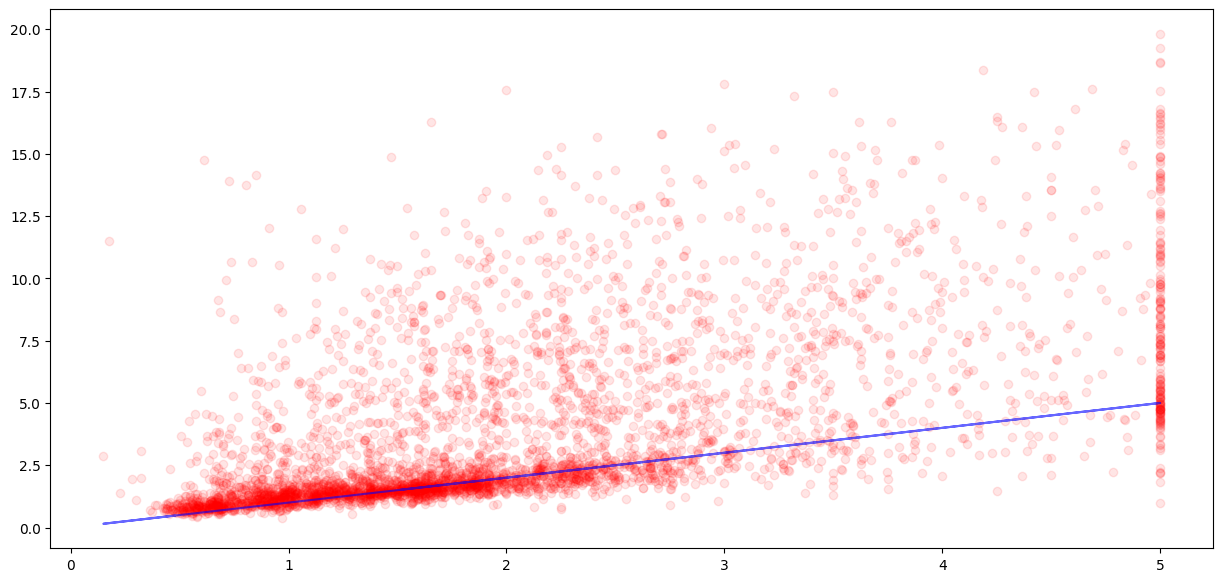

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(y_test, y_test, alpha=0.6, color='blue')
plt.scatter(y_test, y_pred_test, alpha=0.1, color='red')
plt.show()
